## Proof of concept

Triangulation of an image/font

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
Number of contours found: 4
Contour shape: (244, 215, 3)
Number triangles: 86


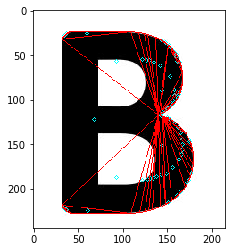

In [17]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt

# ((x1, y1),(x2, y2),(x3, y3))
# C is (x1+x2+x3)/3, (y1+y2+y3)/3.
def calc_centroid(triangle):
    # x1 + x2 + x3    
    cx = (triangle[0] + triangle[2] + triangle[4]) / 3
    # y1 + y2 + y3 
    cy = (triangle[1] + triangle[3] + triangle[5]) / 3
    
    return (cx, cy)

def draw_triangles(img, contour):
    # returns triangles each having 6 points or 3 vectors (x,y)
    triangles = subdiv.getTriangleList() 
    print("Number triangles:", len(triangles))

    for t in triangles:
        p1 = (t[0], t[1])
        p2 = (t[2], t[3])
        p3 = (t[4], t[5])
        
        centroid = calc_centroid(t)
        retval = cv2.pointPolygonTest(contour, centroid, False)
        
        if (retval >= 0):
            cv2.circle(img, (int(centroid[0]), int(centroid[1])), 2, (0, 255, 255))      
            cv2.line(img, p1, p2, (255,0,0))
            cv2.line(img, p2, p3, (255,0,0))
            cv2.line(img, p3, p1, (255,0,0))

# numpy.ndarray - (214, 223, 3)
img_orig = cv2.imread("C:\\Temp\\b1.jpg")
img = img_orig.copy()

# numpy.ndarray - (214, 223)
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
print(img_gray)

# float, numpy.ndarray - (214, 223)
retval, img_bin = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY)
#retval, img_bin  = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#img_bin = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Worst result, produces too many points => 1215 triangles
#contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Better but still too many points => 641 triangles
#contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Better too, but still many points => 295 triangles
#contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)

# Performs best => only 65 triangles!
contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_KCOS)
print("Number of contours found:", len(contours))
#print(contours[1][0])

img_contours = cv2.drawContours(img_orig, contours, 1, (0, 255, 0), 3)
print("Contour shape:", img_contours.shape)

#plt.imshow(img_bin)
#plt.imshow(img_contours)

size = img_contours.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)

points = []
for v in contours[1]:
    points.append((v[0][0], v[0][1]))

for p in points:
    subdiv.insert(p)

draw_triangles(img, contours[1])
    
plt.imshow(img)    

# # Introducing freetype to the concept

Number of contours found: 3
Number of triangles calculated: 350


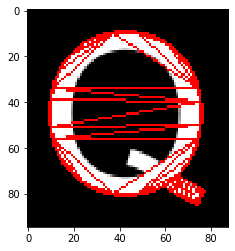

In [1]:
import cv2
import numpy as np
import freetype
from matplotlib import pyplot as plt

# ((x1, y1),(x2, y2),(x3, y3))
# C is (x1+x2+x3)/3, (y1+y2+y3)/3.
def calc_centroid(triangle):
    # x1 + x2 + x3    
    cx = (triangle[0] + triangle[2] + triangle[4]) / 3
    # y1 + y2 + y3 
    cy = (triangle[1] + triangle[3] + triangle[5]) / 3
    
    return (cx, cy)

face = freetype.Face("C:\\Windows\\Fonts\\Arial.ttf")
face.set_char_size(48*128)
face.load_char('Q')
bitmap = face.glyph.bitmap

# Convert bitmap to numpy array
letter = np.array(bitmap.buffer, dtype=np.uint8).reshape(bitmap.rows, bitmap.width)

# Add padding around letter, otherwise we won't find the correct contour
letter = cv2.copyMakeBorder(letter, 10, 10, 10, 10, cv2.BORDER_CONSTANT, None, 0)

# Invert image 
inverted = (255-letter)
#plt.imshow(inverted)

# Convert to binary image, values are either 0 or 255
retval, binary = cv2.threshold(inverted, 100, 255, cv2.THRESH_BINARY)
#plt.imshow(binary)

# cv2.CHAIN_APPROX_NONE results in many triangles, which may be bad for performance
# but this provides the most triangle-representation
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("Number of contours found:", len(contours))

size = letter.shape
rect = (0, 0, size[1], size[0])
subdiv = cv2.Subdiv2D(rect)

c_index = 1

for point in contours[c_index]:
    subdiv.insert((point[0][0], point[0][1]))
    #print(point[0][0], point[0][1])
    
triangles = subdiv.getTriangleList()
print("Number of triangles calculated:", len(triangles))

# Convert letter back to BGR
letter = cv2.cvtColor(letter, cv2.COLOR_GRAY2BGR)

for triangle in triangles:
    p1 = (triangle[0], triangle[1])
    p2 = (triangle[2], triangle[3])
    p3 = (triangle[4], triangle[5])
   
    centroid = calc_centroid(triangle)

    # Test if triangle is part of polygon
    retval = cv2.pointPolygonTest(contours[c_index], centroid, False)
        
    if (retval >= 0):
        #cv2.circle(img, (int(centroid[0]), int(centroid[1])), 2, (0, 255, 255))      
        cv2.line(letter, p1, p2, (255,0,0))
        cv2.line(letter, p2, p3, (255,0,0))
        cv2.line(letter, p3, p1, (255,0,0))    


plt.imshow(letter)        

Using matplotlib backend: TkAgg
